<div style="text-align:center;color:#008BFF;font-weight:1000;font-size:50px">
    Cars - Purchase Decision
</div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from joblib import dump
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import (
    StratifiedKFold, cross_val_score, RandomizedSearchCV
)

In [2]:
df = pd.read_csv("dataset/car_data.csv", index_col="User ID")
df.head()

,Gender,Age,AnnualSalary,Purchased
User ID,,,,
385,Male,35,20000,0
681,Male,40,43500,0
353,Male,49,74000,0
895,Male,40,107500,1
661,Male,25,79000,0


# 1. EDA

In [3]:
df.shape

(1000, 4)

In [4]:
df.groupby("Gender")["Purchased"].sum()

Gender
Female    219
Male      183
Name: Purchased, dtype: int64

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,40.106,10.707073,18.0,32.0,40.0,48.0,63.0
AnnualSalary,1000.0,72689.000,34488.341867,15000.0,46375.0,72000.0,90000.0,152500.0
Purchased,1000.0,0.402,0.490547,0.0,0.0,0.0,1.0,1.0


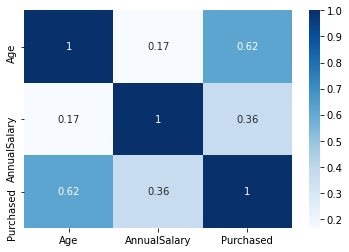

In [6]:
sns.heatmap(df.corr(), annot=True, cmap="Blues");

# 2. Select model

In [7]:
df["Gender"].replace(["Male", "Female"], [1, 0], inplace=True)

X = df.drop("Purchased", axis=1)
y = df["Purchased"]

In [8]:
models = {
    "ExtraTreeClf": ExtraTreesClassifier(),
    "XGBClassifier": XGBClassifier(),
    "LGBMClassifier": LGBMClassifier(),
    "Catboost": CatBoostClassifier(verbose=0)
}

kf = StratifiedKFold(10, shuffle=True, random_state=42)

for name, model in models.items():
    cvs = cross_val_score(model, X, y, cv=kf, scoring="roc_auc")
    mean = cvs.mean()
    std = cvs.std()*3
    
    print(f"{name:<15}: {mean:.2f} (+/- {std:.2f})")

ExtraTreeClf   : 0.94 (+/- 0.08)
XGBClassifier  : 0.96 (+/- 0.05)
LGBMClassifier : 0.96 (+/- 0.05)
Catboost       : 0.97 (+/- 0.05)


# 3. Hyperparameter tuning

In [9]:
params = {
    "max_depth": [2, 3, 4, 5, 6],
    "reg_lambda": np.linspace(0, 1, 20),
    "n_estimators": [100, 200, 500, 800, 1000],
    "learning_rate": np.linspace(0.00001, 0.7, 50)
}

model = RandomizedSearchCV(
    CatBoostClassifier(random_state=42, verbose=0),
    params,
    n_iter = 50,
    scoring = "roc_auc",
    cv = kf
).fit(X, y)

print("Best score: ",model.best_score_)
print(model.best_params_)

Best score:  0.9725500723439439
{'reg_lambda': 0.10526315789473684, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.028581020408163266}


# 4. Export model

In [10]:
dump(model, 'model/car_purchase.joblib')

['model/car_purchase.joblib']